# **Backpack Prediction Challenge**

# Imports & Environment Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import optuna
import os

# Load Data & Initial Checks

In [14]:
# Load data
train_path = "./data/train.csv"
train_extra_path = "./data/training_extra.csv"
test_path = "./data/test.csv"
submission_path = "./data/sample_submission.csv"

df_train = pd.read_csv(train_path)
df_train_extra = pd.read_csv(train_extra_path)
df_test = pd.read_csv(test_path)
df_submission = pd.read_csv(submission_path)

# Display basic information about datasets
def dataset_info(df, name):
    print(f"\n{name} Dataset:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("Missing Values:")
    print(df.isnull().sum())
    print("--------------------------------\n")

# Check each dataset
dataset_info(df_train, "Train")
dataset_info(df_train_extra, "Train Extra")
dataset_info(df_test, "Test")
dataset_info(df_submission, "Sample Submission")

# Check for duplicate rows
print("Duplicates in Train:", df_train.duplicated().sum())
print("Duplicates in Train Extra:", df_train_extra.duplicated().sum())
print("Duplicates in Test:", df_test.duplicated().sum())



Train Dataset:
Shape: (300000, 11)
Columns: ['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price']
Missing Values:
id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64
--------------------------------


Train Extra Dataset:
Shape: (3694318, 11)
Columns: ['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price']
Missing Values:
id                           0
Brand                   117053
Material                102615
Size                     81190
Compartments                 0
Laptop Compartment       91089
Waterproof               87274
Style     

# EDA (Exploratory Data Analysis)


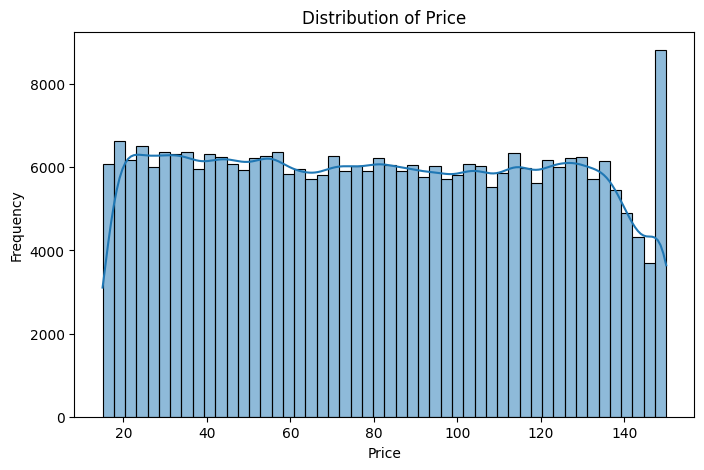

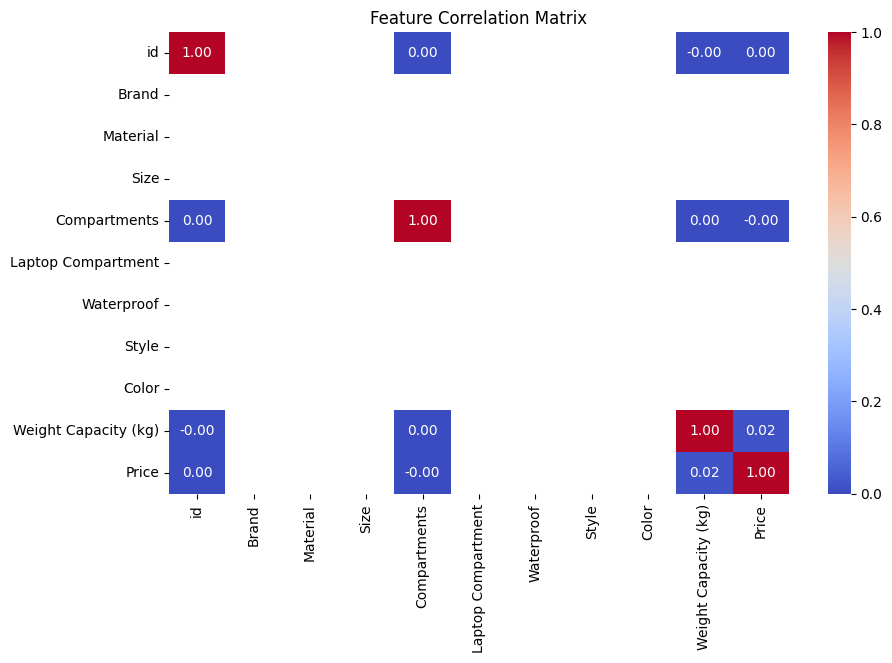

In [4]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 5))
sns.histplot(df_train['Price'], bins=50, kde=True)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Ensure all numeric columns are correctly formatted
df_train = df_train.apply(pd.to_numeric, errors='coerce')  # Convert where possible

# Correlation heatmap (numerical columns only)
plt.figure(figsize=(10, 6))
numeric_cols = df_train.select_dtypes(include=['number']).columns  # Select only numeric columns
corr_matrix = df_train[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Check categorical feature distributions
categorical_cols = df_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=df_train[col], order=df_train[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show()


# Data Preprocessing (Handle Missing Values, Encoding, Feature Engineering)

In [6]:
# Step 4: Data Preprocessing & Feature Engineering
# Ensure numeric columns are properly filled
df_train = df_train.copy()  # Avoids potential chained assignment issues
numeric_cols = df_train.select_dtypes(include=['number']).columns

# Drop fully missing columns
fully_missing_cols = [col for col in numeric_cols if df_train[col].isnull().all()]
df_train.drop(columns=fully_missing_cols, inplace=True)

# Fill missing numeric values only for partially missing columns
df_train[numeric_cols] = df_train[numeric_cols].apply(lambda col: col.fillna(col.median()) if col.isnull().sum() > 0 else col)

# Ensure categorical columns are properly filled before encoding
categorical_cols = df_train.select_dtypes(include=['object']).columns
df_train[categorical_cols] = df_train[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Encoding categorical variables
label_encoders = {}
for col in categorical_cols:
    lbl = LabelEncoder()
    df_train[col] = lbl.fit_transform(df_train[col].astype(str))  # Convert to string to avoid NaN issues
    label_encoders[col] = lbl  # Store encoders for later use

# Feature Engineering
df_train['Log_Price'] = np.log1p(df_train['Price'])  # Log transformation to normalize price

# Display updated dataset information
dataset_info(df_train, "Train After Preprocessing")



Train After Preprocessing Dataset:
Shape: (300000, 5)
Columns: ['id', 'Compartments', 'Weight Capacity (kg)', 'Price', 'Log_Price']
Missing Values:
id                      0
Compartments            0
Weight Capacity (kg)    0
Price                   0
Log_Price               0
dtype: int64
--------------------------------



# Train-Test Split & Scaling

In [7]:
# Step 5: Train-Test Split & Data Scaling
X = df_train.drop(columns=['Price', 'Log_Price', 'id'])  # Remove target & ID columns
y = df_train['Log_Price']  # Use log-transformed price as target

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Train-Test Split & Scaling Completed!")

Train-Test Split & Scaling Completed!


# Model Selection & Baseline Model

In [8]:
# Step 6: Model Training & Evaluation
# Train a baseline Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_val_scaled)

# Evaluate Random Forest model
rf_mae = mean_absolute_error(y_val, y_pred_rf)
rf_rmse = mean_squared_error(y_val, y_pred_rf, squared=False)
print(f"Random Forest MAE: {rf_mae:.4f}")
print(f"Random Forest RMSE: {rf_rmse:.4f}")

# Train a LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05)
lgb_model.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_model.predict(X_val_scaled)

# Evaluate LightGBM model
lgb_mae = mean_absolute_error(y_val, y_pred_lgb)
lgb_rmse = mean_squared_error(y_val, y_pred_lgb, squared=False)
print(f"LightGBM MAE: {lgb_mae:.4f}")
print(f"LightGBM RMSE: {lgb_rmse:.4f}")

print("Model Training & Evaluation Completed!")


C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest MAE: 0.5316
Random Forest RMSE: 0.6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
LightGBM MAE: 0.4827
LightGBM RMSE: 0.5798
Model Training & Evaluation Completed!


C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Hyperparameter Tuning

In [9]:
# Step 7: Hyperparameter Tuning with Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300, step=10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    return mean_squared_error(y_val, y_pred, squared=False)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best Optuna Params:", study.best_params)
best_params = study.best_params

# Train the best LightGBM model
best_lgb_model = lgb.LGBMRegressor(**best_params)
best_lgb_model.fit(X_train_scaled, y_train)
y_pred_best = best_lgb_model.predict(X_val_scaled)

# Evaluate the tuned LightGBM model
best_lgb_mae = mean_absolute_error(y_val, y_pred_best)
best_lgb_rmse = mean_squared_error(y_val, y_pred_best, squared=False)
print(f"Tuned LightGBM MAE: {best_lgb_mae:.4f}")
print(f"Tuned LightGBM RMSE: {best_lgb_rmse:.4f}")

print("Hyperparameter Tuning & Model Selection Completed!")


[I 2025-02-27 15:04:59,031] A new study created in memory with name: no-name-2fc367c1-0617-457d-aaf1-33a1d1ae48c9


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:04:59,663] Trial 0 finished with value: 0.5791472108780809 and parameters: {'n_estimators': 100, 'learning_rate': 0.014072498720324294, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 20, 'subsample': 0.7172778989967048, 'colsample_bytree': 0.6703049242394339}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:04,978] Trial 1 finished with value: 0.5791957719629854 and parameters: {'n_estimators': 800, 'learning_rate': 0.010976871769567806, 'max_depth': 10, 'num_leaves': 80, 'min_child_samples': 90, 'subsample': 0.5960732465891416, 'colsample_bytree': 0.5020359993460773}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:09,977] Trial 2 finished with value: 0.5817217873849733 and parameters: {'n_estimators': 500, 'learning_rate': 0.0999896863326401, 'max_depth': 8, 'num_leaves': 280, 'min_child_samples': 30, 'subsample': 0.6918355290747529, 'colsample_bytree': 0.8652615013531547}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:11,672] Trial 3 finished with value: 0.5800802869195386 and parameters: {'n_estimators': 300, 'learning_rate': 0.06713232151277193, 'max_depth': 7, 'num_leaves': 60, 'min_child_samples': 20, 'subsample': 0.6827084873673022, 'colsample_bytree': 0.9716763640577559}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:14,850] Trial 4 finished with value: 0.5792726562539114 and parameters: {'n_estimators': 700, 'learning_rate': 0.1514847253047661, 'max_depth': 8, 'num_leaves': 120, 'min_child_samples': 80, 'subsample': 0.7543287676627872, 'colsample_bytree': 0.7256109781714959}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:17,945] Trial 5 finished with value: 0.5792507521541844 and parameters: {'n_estimators': 500, 'learning_rate': 0.02934582078343727, 'max_depth': 14, 'num_leaves': 100, 'min_child_samples': 60, 'subsample': 0.7429830595543899, 'colsample_bytree': 0.6052125099328152}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:22,824] Trial 6 finished with value: 0.5792732424330311 and parameters: {'n_estimators': 1000, 'learning_rate': 0.10370256282953151, 'max_depth': 13, 'num_leaves': 40, 'min_child_samples': 30, 'subsample': 0.9024677217893471, 'colsample_bytree': 0.6438599315578357}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:26,138] Trial 7 finished with value: 0.5801912264109407 and parameters: {'n_estimators': 200, 'learning_rate': 0.0275670499791427, 'max_depth': 12, 'num_leaves': 240, 'min_child_samples': 85, 'subsample': 0.8077189322093165, 'colsample_bytree': 0.8685982447271103}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544


C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:31,853] Trial 8 finished with value: 0.582025247052303 and parameters: {'n_estimators': 1000, 'learning_rate': 0.15864171555469192, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 55, 'subsample': 0.8474018867880264, 'colsample_bytree': 0.9143486539681243}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:37,510] Trial 9 finished with value: 0.5792701669959455 and parameters: {'n_estimators': 700, 'learning_rate': 0.039893505979570074, 'max_depth': 14, 'num_leaves': 130, 'min_child_samples': 10, 'subsample': 0.9596884409583899, 'colsample_bytree': 0.6719277394733325}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:38,309] Trial 10 finished with value: 0.5791785202695284 and parameters: {'n_estimators': 100, 'learning_rate': 0.01105808777424008, 'max_depth': 3, 'num_leaves': 190, 'min_child_samples': 5, 'subsample': 0.5344208531317204, 'colsample_bytree': 0.8009109586739824}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:38,860] Trial 11 finished with value: 0.5791766918058991 and parameters: {'n_estimators': 100, 'learning_rate': 0.011440683082943784, 'max_depth': 3, 'num_leaves': 200, 'min_child_samples': 5, 'subsample': 0.5165119664691964, 'colsample_bytree': 0.7933969981422697}. Best is trial 0 with value: 0.5791472108780809.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:40,041] Trial 12 finished with value: 0.5791400418539743 and parameters: {'n_estimators': 300, 'learning_rate': 0.017662402641257062, 'max_depth': 3, 'num_leaves': 180, 'min_child_samples': 40, 'subsample': 0.5258960106106672, 'colsample_bytree': 0.7512378653875614}. Best is trial 12 with value: 0.5791400418539743.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:42,801] Trial 13 finished with value: 0.5790993861867982 and parameters: {'n_estimators': 300, 'learning_rate': 0.019647497335817166, 'max_depth': 5, 'num_leaves': 160, 'min_child_samples': 40, 'subsample': 0.6249145500348282, 'colsample_bytree': 0.5662806014998732}. Best is trial 13 with value: 0.5790993861867982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:05:56,547] Trial 14 finished with value: 0.5791011655356877 and parameters: {'n_estimators': 400, 'learning_rate': 0.019696767668882228, 'max_depth': 5, 'num_leaves': 180, 'min_child_samples': 45, 'subsample': 0.6029803098078766, 'colsample_bytree': 0.5359508080102467}. Best is trial 13 with value: 0.5790993861867982.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:06:05,576] Trial 15 finished with value: 0.5791014000381791 and parameters: {'n_estimators': 400, 'learning_rate': 0.02033687964420965, 'max_depth': 5, 'num_leaves': 240, 'min_child_samples': 70, 'subsample': 0.618662114872462, 'colsample_bytree': 0.506957978704228}. Best is trial 13 with value: 0.5790993861867982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:06:17,992] Trial 16 finished with value: 0.5791289964605606 and parameters: {'n_estimators': 400, 'learning_rate': 0.04757765022509064, 'max_depth': 5, 'num_leaves': 160, 'min_child_samples': 40, 'subsample': 0.598761450725971, 'colsample_bytree': 0.5806196359105753}. Best is trial 13 with value: 0.5790993861867982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:06:20,863] Trial 17 finished with value: 0.5791029895239181 and parameters: {'n_estimators': 300, 'learning_rate': 0.026389110629175018, 'max_depth': 5, 'num_leaves': 220, 'min_child_samples': 45, 'subsample': 0.6415617622150123, 'colsample_bytree': 0.5658307476889531}. Best is trial 13 with value: 0.5790993861867982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:06:32,801] Trial 18 finished with value: 0.5792734031210041 and parameters: {'n_estimators': 600, 'learning_rate': 0.24717416770448666, 'max_depth': 10, 'num_leaves': 300, 'min_child_samples': 65, 'subsample': 0.5674653420743256, 'colsample_bytree': 0.5506405791533763}. Best is trial 13 with value: 0.5790993861867982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-27 15:06:34,503] Trial 19 finished with value: 0.5791407516069724 and parameters: {'n_estimators': 400, 'learning_rate': 0.03888041185617106, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 50, 'subsample': 0.6359934522154832, 'colsample_bytree': 0.6263844410855967}. Best is trial 13 with value: 0.5790993861867982.


Best Optuna Params: {'n_estimators': 300, 'learning_rate': 0.019647497335817166, 'max_depth': 5, 'num_leaves': 160, 'min_child_samples': 40, 'subsample': 0.6249145500348282, 'colsample_bytree': 0.5662806014998732}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

C:\Users\mones\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


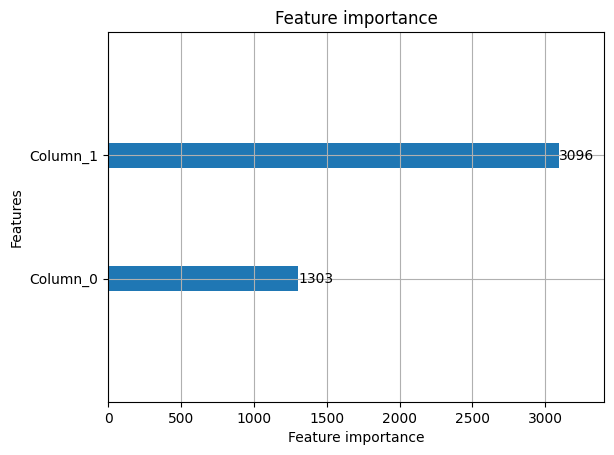

In [10]:
lgb.plot_importance(best_lgb_model)
plt.show()

In [11]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_lgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
print(feature_importance)


                Feature  Importance
1  Weight Capacity (kg)        3096
0          Compartments        1303


In [12]:
print(f"Previous LightGBM MAE: {lgb_mae:.4f}")
print(f"Previous LightGBM RMSE: {lgb_rmse:.4f}")

print(f"Tuned LightGBM MAE: {best_lgb_mae:.4f}")
print(f"Tuned LightGBM RMSE: {best_lgb_rmse:.4f}")

Previous LightGBM MAE: 0.4827
Previous LightGBM RMSE: 0.5798
Tuned LightGBM MAE: 0.4824
Tuned LightGBM RMSE: 0.5791


# Ensemble Learning (Optional)

# Preprocess Test Data & Generate Predictions

In [17]:
# Step 8: Final Model Training (Retraining on Full Data)
final_lgb_model = lgb.LGBMRegressor(**best_params)
final_lgb_model.fit(X_train_scaled, y_train)
print("Final Model Retrained on Full Dataset!")

# Step 9: Preprocess Test Data & Generate Predictions
df_test = df_test.copy()
numeric_cols_test = df_test.select_dtypes(include=['number']).columns
df_test[numeric_cols_test] = df_test[numeric_cols_test].apply(lambda col: col.fillna(col.median()))
df_test[categorical_cols] = df_test[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))
for col in categorical_cols:
    if col in label_encoders:
        df_test[col] = df_test[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)

X_test = df_test[X_train.columns]  # Ensure same column order
X_test_scaled = scaler.transform(X_test)

test_predictions = final_lgb_model.predict(X_test_scaled)
df_submission['Price'] = np.expm1(test_predictions)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 4.267544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

# Submission & Evaluation

In [18]:
# Step 10: Submission & Evaluation
df_submission.to_csv('submission.csv', index=False)
print("Final Submission file saved as submission.csv")

Final Submission file saved as submission.csv
